In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
from tsfresh.feature_extraction import extract_features

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.decomposition import PCA

from imblearn.ensemble import BalancedRandomForestClassifier

from xgboost import XGBClassifier

In [2]:
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set figures to display in higher res

In [3]:
# import data and split out features and outcomes
filepath = os.path.join('.', 'data', 'processed', 'features_and_outcomes.csv')
df = pd.read_csv(filepath)
features = df.drop(['RecordID', 'In-hospital_death'], axis=1)
y = df['In-hospital_death']

### Create ScoreTracker class to store and plot model performance

In [16]:
class ScoreTracker:
    
    def __init__(self):
        self.score_dict_ = {'model_name':[], 'mean_test_score':[], 'std_test_score':[]}
    
    def add_best_score(self, CV, model_name):
        '''
        Adds mean and stddev of CV score for a CV object
        '''
        cv_results = pd.DataFrame(CV.cv_results_)
        mean_test_score = cv_results.loc[cv_results['rank_test_score']==1, 'mean_test_score'].iloc[0]
        std_test_score = cv_results.loc[cv_results['rank_test_score']==1, 'std_test_score'].iloc[0]
        self.score_dict_['model_name'].append(model_name)
        self.score_dict_['mean_test_score'].append(mean_test_score)
        self.score_dict_['std_test_score'].append(std_test_score)
        
    def plot_scores(self):
        num_bars = len(self.score_dict_['model_name'])
        fig, ax = plt.subplots(figsize=(6, 0.4*num_bars))
        clrs = ['slategrey' if score < max(self.score_dict_['mean_test_score']) else 'seagreen' for score in self.score_dict_['mean_test_score']]
        ax.barh(self.score_dict_['model_name'], self.score_dict_['mean_test_score'],
                xerr=self.score_dict_['std_test_score'], color=clrs)
        ax.set_xlabel('Mean CV Score')
        plt.show()

    def get_score_df(self):
        return pd.DataFrame(self.score_dict_)

# Feature Selection

### Remove sparse features
Use a baseline model to test different thresholds of dropping features based on their percent of null values

In [5]:
# use logistic regression as baseline model
lr = LogisticRegression(solver='liblinear', random_state=42)

lr_baseline_params = {
    'penalty':['l1', 'l2']
}

lr_baseline = GridSearchCV(estimator=lr, cv=3, param_grid=lr_baseline_params,
                            verbose=0, n_jobs=-1, scoring='f1',
                            return_train_score=False)

In [6]:
# create mean imputer and scaler
imp = SimpleImputer()
ss = StandardScaler()

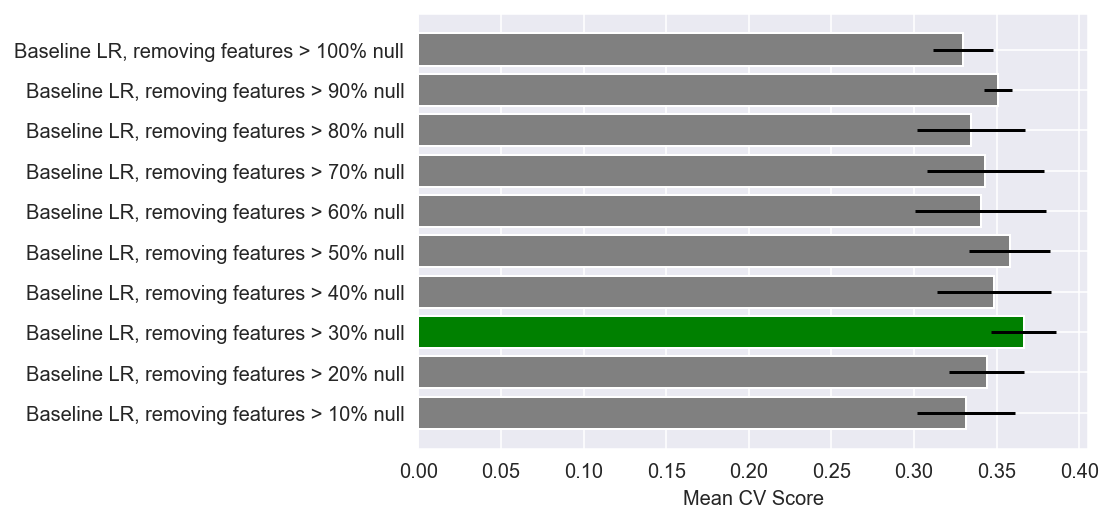

In [7]:
null_scores = ScoreTracker()

# try different null removal thresholds
for null_threshold in np.linspace(0.1, 1.0, 10):
    # remove sparse columns
    X = features.loc[:, features.isnull().mean() <= null_threshold]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # impute mean and standardize
    X_train_imp = imp.fit_transform(X_train)
    X_train_imp_ss = ss.fit_transform(X_train_imp)
    
    #test baseline model and add scores
    lr_baseline.fit(X_train_imp_ss, y_train)
    null_scores.add_best_score(lr_baseline, 'Baseline LR, removing features > {:2.0%} null'.format(null_threshold))

null_scores.plot_scores()

Removing features that were more than 30% null yields the best Mean CV score, though it looks like the differences may not be statistically significant (just looking at the std deviation of CV scores)

In [8]:
# Remove features > 30% null
X = features.loc[:, features.isnull().mean() <= 0.3]

# perform train_test_split, ensure it is stratified because the dataset is imablanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

In [9]:
print(features.shape)
print(X.shape)

(4000, 586)
(4000, 211)


After removing sparse columns, we've reduced our total number of features from 586 to 211

In [10]:
# create mean imputed data
X_train_imp = imp.fit_transform(X_train)
X_test_imp = imp.transform(X_test)

# use standard scaling on imputed data
X_train_imp_ss = ss.fit_transform(X_train_imp)
X_test_imp_ss = ss.transform(X_test_imp)

### Investigate collinearity
After removing nulls, it's clear that there are numerous collinear features (hot and cold spots in clustermap). I looked into the impact of removing collinear features (through PCA) on the baseline model performance

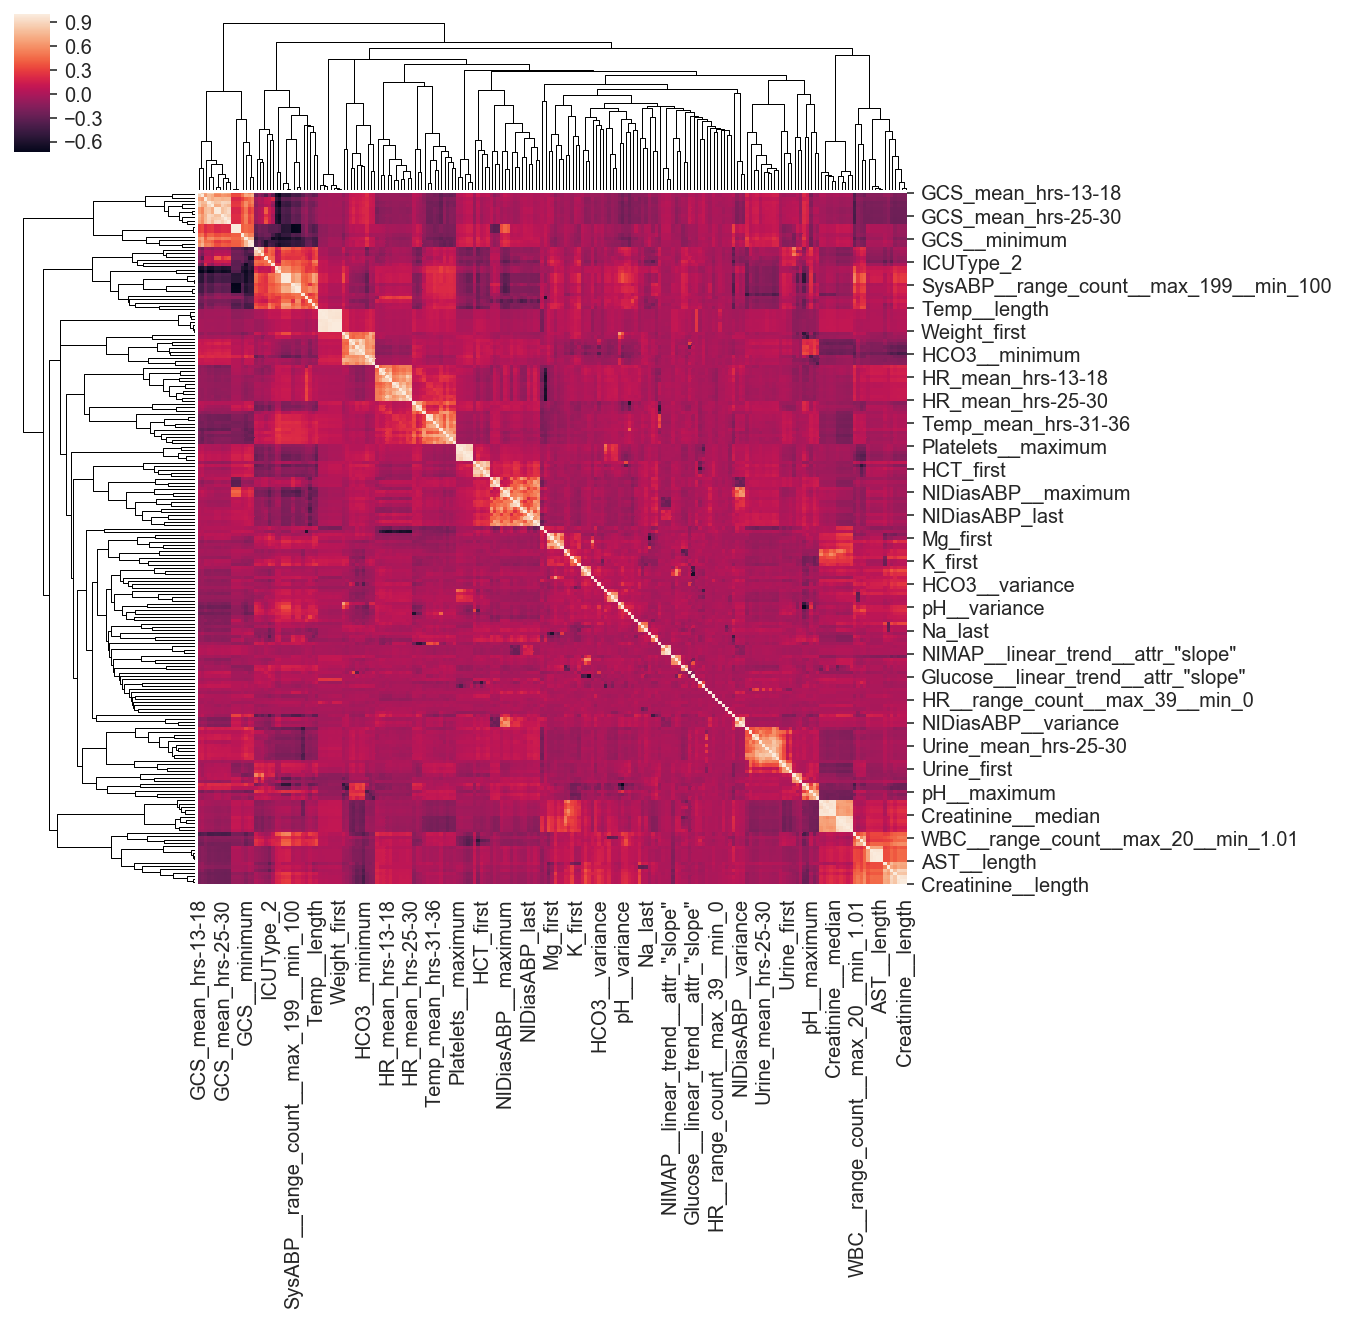

In [11]:
sns.clustermap(X.corr(), figsize=(8,8))

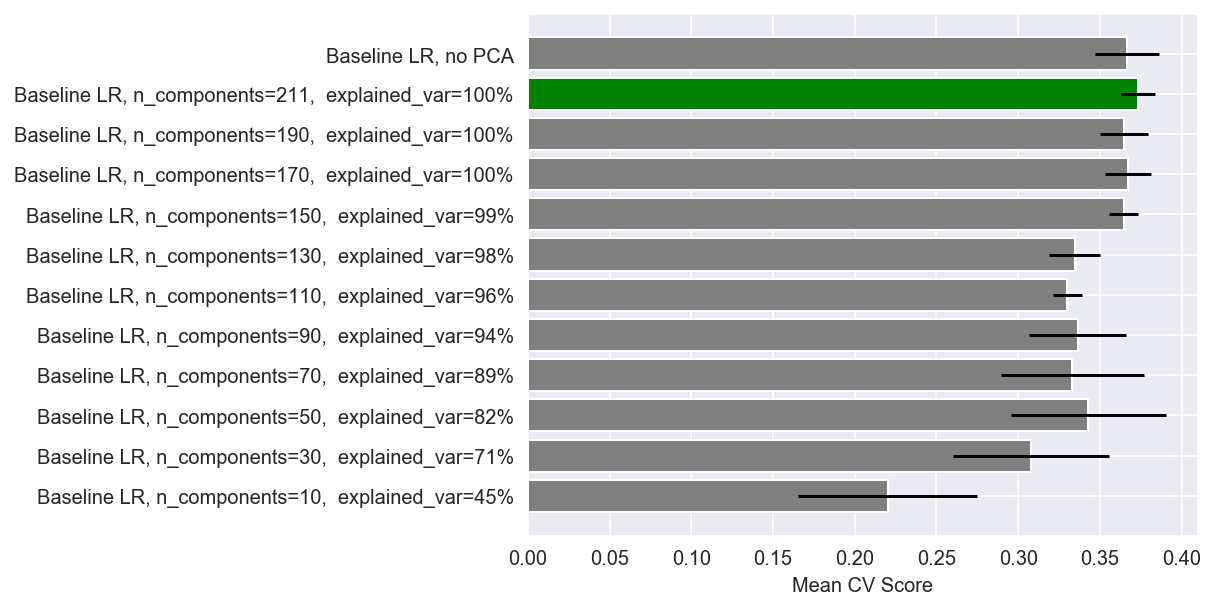

In [12]:
pca_scores = ScoreTracker()

# try different numbers of principal components
for n in np.linspace(10, len(X.columns), 11):
    # perform PCA
    pca = PCA(n_components=int(n))
    X_train_pca = pca.fit_transform(X_train_imp_ss)
    explained_var = sum(pca.explained_variance_ratio_)
    
    # test baseline model and add score
    lr_baseline.fit(X_train_pca, y_train)
    pca_scores.add_best_score(lr_baseline, 'Baseline LR, n_components={:},  explained_var={:2.0%}'.format(int(n), explained_var))

# try no PCA
lr_baseline.fit(X_train_imp_ss, y_train)
pca_scores.add_best_score(lr_baseline, 'Baseline LR, no PCA')
    
pca_scores.plot_scores()

PCA doesn't significantly improve model performance. Plus, we still want to retain interpretability of our features, so PCA doesn't fit well into our workflow. <br>
However, it's clear that there are numerous highly correlated features (explained variance is very high even at 130 components), so let's explore feature elimination

### Feature selection with Recursive Feature Elimination
I wanted to see how removing features affects model performance

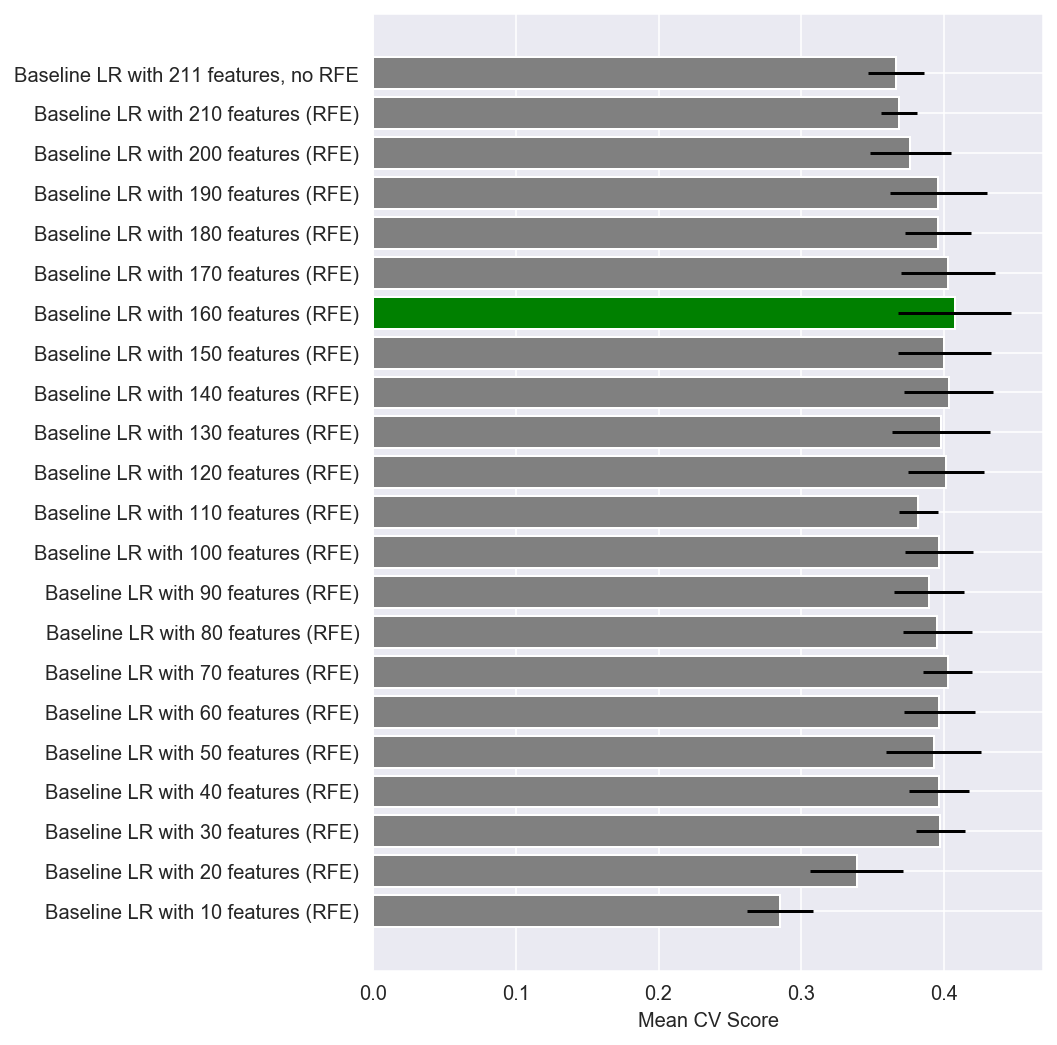

In [15]:
rfe_scores = ScoreTracker()

# try different numbers of features to select
for n in np.linspace(10, 210, 21):
    #remove features
    rfe = RFE(LogisticRegression(solver='liblinear'), n_features_to_select=int(n), step=10, verbose=0)
    rfe.fit(X_train_imp_ss, y_train)
    X_train_rfe = rfe.transform(X_train_imp_ss)
    
    # test baseline model and add score
    lr_baseline.fit(X_train_rfe, y_train)
    rfe_scores.add_best_score(lr_baseline, 'Baseline LR with {:} features (RFE)'.format(int(n)))

# try no PCA
lr_baseline.fit(X_train_imp_ss, y_train)
rfe_scores.add_best_score(lr_baseline, 'Baseline LR with {:} features, no RFE'.format(X_train_imp_ss.shape[1]))

rfe_scores.plot_scores()

It seems like removing features does improve model performance. Based on these results, let's eliminate all but 160 features and use that dataset for modeling

In [20]:
# reduce to 160 features
rfe = RFE(LogisticRegression(solver='liblinear'), n_features_to_select=160, step=10, verbose=0)
rfe.fit(X_train_imp_ss, y_train)
X_train_rfe = rfe.transform(X_train_imp_ss)
X_test_rfe = rfe.transform(X_test_imp_ss)

# Model Selection
So far, we've testing logistic regression as a baseline model using an F1 score. Given that the contest is scored using the minimum of precision and recall, sticking with F1 score is still a reasonable approach as it balances the two metrics.

The following models are tested below:
* Logistic Regression
* Random Forest
* Balanced Random Forest
* XGBoost

In [21]:
def score_model(estimator, param_grid, X_train, y_train, ScoreTracker, model_name):
    '''
    Performs a GridSearchCV on estimator using param_grid, X_train, and y_train.
    Stores the best score into ScoreTracker with the specified model_name
    '''
    gscv = GridSearchCV(estimator=estimator, cv=3, param_grid=param_grid,
                        verbose=0, n_jobs=-1, scoring='f1',
                        return_train_score=False)
    gscv.fit(X_train, y_train)
    ScoreTracker.add_best_score(GridSearchCV=gscv, model_name=model_name)

### Baseline Models
The first step is to test our algorithms without tuning hyperparameters. 

In [26]:
# instantiate models and score tracker
lr = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(random_state=42)
brf = BalancedRandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_scores = ScoreTracker()

# create baseline parameters
lr_baseline_params = {
    'penalty':['l2']
}

rf_baseline_params = {
    'n_estimators': [100]
}

brf_baseline_params = rf_baseline_params

xgb_baseline_params = {
    'max_depth': [3]
}

# create baseline GridSearchCVs
lr_baseline = GridSearchCV(estimator=lr, cv=3, param_grid=lr_baseline_params,
                            verbose=0, n_jobs=-1, scoring='f1',
                            return_train_score=False)

rf_baseline = GridSearchCV(estimator=rf, cv=3, param_grid=rf_baseline_params,
                            verbose=0, n_jobs=-1, scoring='f1',
                            return_train_score=False)

brf_baseline = GridSearchCV(estimator=brf, cv=3, param_grid=brf_baseline_params,
                            verbose=0, n_jobs=-1, scoring='f1',
                            return_train_score=False)

xgb_baseline = GridSearchCV(estimator=xgb, cv=3, param_grid=xgb_baseline_params,
                            verbose=0, n_jobs=-1, scoring='f1',
                            return_train_score=False)

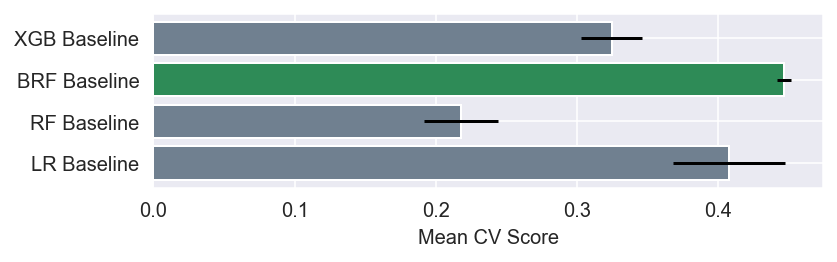

In [27]:
# test and plot baseline model performance
lr_baseline.fit(X_train_rfe, y_train)
rf_baseline.fit(X_train_rfe, y_train)
brf_baseline.fit(X_train_rfe, y_train)
xgb_baseline.fit(X_train_rfe, y_train)
model_scores.add_best_score(lr_baseline, 'LR Baseline')
model_scores.add_best_score(rf_baseline, 'RF Baseline')
model_scores.add_best_score(brf_baseline, 'BRF Baseline')
model_scores.add_best_score(xgb_baseline, 'XGB Baseline')

model_scores.plot_scores()

It looks like balanced random forest is performing the best out of the box, and random forest is performing the worst. Given that our classes are imbalanced, this isn't surprising. The next step is to tune hyperparameters using a random search / Grid Search

### Hyperparameter Tuning

For tuning the Logistic Regression model, I started with a grid search since there are only 2 hyperparameters to tune

In [31]:
# parameters used for Logistic Regression grid search
lr_grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [10**x for x in np.linspace(-4, 3, 15)]
}

lr_grid = GridSearchCV(estimator=lr, cv=3, param_grid=lr_grid_params,
                       verbose=1, n_jobs=-1, scoring='f1',
                       return_train_score=False)
lr_grid.fit(X_train_rfe, y_train)

model_scores.add_best_score(lr_grid, 'LR Grid')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   27.8s finished


For tuning RandomForest, BalancedRandomForest, and XGBoost, I start with a RandomSearch to understand the range of optimal values for each hyperparameter, then perform a more targeted GridSearch

In [35]:
# params used for both RandomForest and BalancedRandomForest
rf_random_params = {
    'n_estimators': [10, 100, 200, 1000, 2000],
    'max_depth': [4, 8, 16, None],
    'min_samples_split': [2, 8, 32, 128],
    'min_samples_leaf': [1, 2, 8, 32, 128], 
    'max_features': ['auto', 'log2', None],
    'bootstrap': [True]
}

brf_random_params = rf_random_params

# parameters used for XGBoost
xgb_random_params = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'learning_rate': [.01, .03, .06, .1, .13, .16, .2],
    'subsample': np.linspace(0.1, 1, 10),
    'max_depth': [2, 3, 5, 8, 12, 16],
    'colsample_bytree': np.linspace(0.1, 1, 10),
    'gamma': [0, 0.1, 1, 5],
    'min_child_weight': [1, 3, 5, 7, 9],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100],
}

xgb_random = RandomizedSearchCV(xgb, xgb_random_params, n_iter=100,
                          scoring='f1', verbose=1, n_jobs=-1,
                          cv=3)
xgb_random.fit(X_train_rfe, y_train)

model_scores.add_best_score(xgb_random, 'XGB Random')

print(xgb_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


{'subsample': 0.30000000000000004, 'reg_lambda': 0.01, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.06, 'gamma': 0.1, 'colsample_bytree': 0.4}
